# ANALYSIS - 1

# What causes difference in Prices of listings?

In [2]:
from collections import Counter
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
matplotlib.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#read the dataset
calendar_boston = pd.read_csv("./Boston/calendar.csv")
listings_boston = pd.read_csv("./Boston/listings.csv")
reviews_boston = pd.read_csv("./Boston/reviews.csv")

calendar_seatle = pd.read_csv("./Seatle/calendar.csv")
listings_seatle = pd.read_csv("./Seatle/listings.csv")
reviews_seatle = pd.read_csv("./Seatle/reviews.csv")

In [5]:
###Dimension of datasets
#------------------------Calendar

print("Dimension df for Calendar for Boston:", calendar_boston.shape)
print("Dimension df for Calendar for Seatle:", calendar_seatle.shape)
#-------------------------Listings

print("Dimension df for Listings for Boston:", listings_boston.shape)
print("Dimension df for Listings for Seatle:", listings_seatle.shape)


#---------------------------reviews

print("Dimension df for Reviews for Boston:", calendar_boston.shape)
print("Dimension df for Reviews for Seatle:", calendar_seatle.shape)

Dimension df for Calendar for Boston: (1308890, 4)
Dimension df for Calendar for Seatle: (1393570, 4)
Dimension df for Listings for Boston: (3585, 95)
Dimension df for Listings for Seatle: (3818, 92)
Dimension df for Reviews for Boston: (1308890, 4)
Dimension df for Reviews for Seatle: (1393570, 4)


From the results above we can noticed that we have more data in Boston datasets. For the other hand, we have more variables in the Boston Listings Dataset than Seatle, we will check this result deeper and get insights. Now let's join the datasets.

In calendar's daframes we have information about dates and price of specific airbnb (listing_id). For both datasets we have a lot of null values in price variable!

In [6]:
columns_lb= listings_boston.columns
columns_ls = listings_seatle.columns

aux = []

for column in columns_lb:
    if column not in columns_ls:
        aux.append(column)

print("We don't have this information in Seatle data:",aux)

#We drop this variables.

listings_boston.drop(aux, axis=1,inplace=True)

We don't have this information in Seatle data: ['access', 'interaction', 'house_rules']


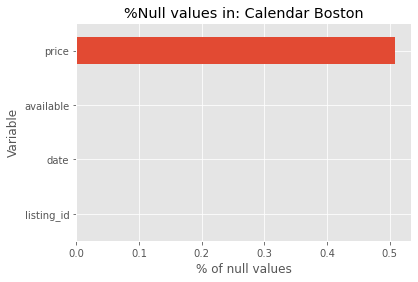

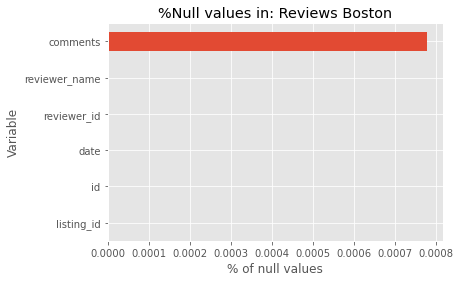

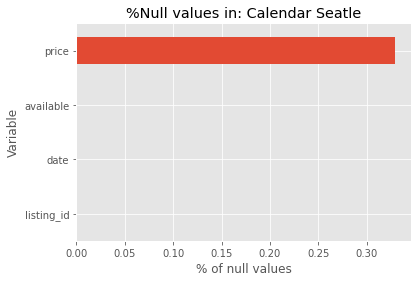

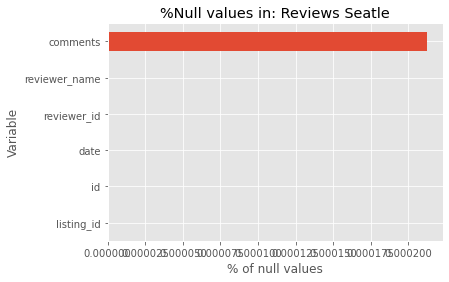

In [7]:
def plot_null_values(df, ss):
    '''
    Input: Dataframe
    Output: Plot for the percentage of null values in dataset
    '''
    df_aux = df.isnull().sum()/df.shape[0]
    df_aux.plot(kind='barh')
    plt.title("%Null values in: "+ ss)
    plt.ylabel("Variable")
    plt.xlabel("% of null values")
    #plt.savefig("/images/"+ss+'.png')
    plt.show()

    
boston_dfs = { "Calendar Boston": calendar_boston, 
              "Reviews Boston": reviews_boston}

seatle_dfs = { "Calendar Seatle": calendar_seatle,
              "Reviews Seatle": reviews_seatle}

for name, df in boston_dfs.items():
     plot_null_values(df, name)
        
for name, df in seatle_dfs.items():
     plot_null_values(df, name)

In [8]:
### Join the datasets

calendar_boston['city'] = "Boston"
calendar_boston.to_csv('calendar_boston.csv')
calendar_seatle["city"] = "Seatle"
calendar_seatle.to_csv('calendar_seatle.csv')
calendar = pd.concat([calendar_boston, calendar_seatle], axis=0)
calendar.to_csv('calendar.csv')
print("Calendar listings unique values.", calendar.drop_duplicates("listing_id").shape[0]/calendar.shape[0])


listings_boston["city"] = "Boston"
listings_seatle["city"] = "Seatle"
listings = pd.concat([listings_boston, listings_seatle], axis=0)
listings.to_csv('listings.csv')
print("Listings unique values.", listings.drop_duplicates("id").shape[0]/listings.shape[0])

reviews_boston["city"] = "Boston"
reviews_boston.to_csv('reviews_boston.csv')
reviews_seatle["city"] = "Seatle"
reviews_seatle.to_csv('reviews_seatle.csv')
reviews = pd.concat([reviews_boston, reviews_seatle],axis=0)
reviews.to_csv('reviews.csv')
print("Reviews unique values:", reviews.drop_duplicates("listing_id").shape[0]/ reviews.shape[0])

Calendar listings unique values. 0.0027393559941682765
Listings unique values. 1.0
Reviews unique values: 0.03931454246231812


We have 3 datasets and we can infer that the calendar dataset contains information about the reservation of each available Airbnbn (7403). Listings dataset has a specific description of each Airbnb, so we have information about the neighborhood, scores, price, number of bedrooms, and others. I believe the Calendar dataset is not very useful.

In [9]:
# Cleaning the data
def Cleaning_DF(inputDF):
    inputDF=inputDF[['city','id','name','summary','longitude','latitude','space','description','instant_bookable','neighborhood_overview','neighbourhood_cleansed','host_id','host_name','host_since',
                     'host_response_time','street', 'zipcode','review_scores_rating','property_type','room_type','accommodates','bathrooms','bedrooms','beds','reviews_per_month','amenities','cancellation_policy','number_of_reviews','price']]

    # replacing NaN values with 0
    inputDF.fillna(0, inplace=True)

    #Extracting prices from the table
    price = inputDF['price']
    prices=[]

    #clean the data to make it float
    for p in price:
        p=float(p[1:].replace(',',''))
        prices.append(p)

    #replace the price column with the new column
    inputDF['price']=prices
    
    inputDF['price']=inputDF['price'].apply(lambda x: int(x))
    #exclude the listings with 0 for price,beds,bedrooms,accomodates etc
    inputDF = inputDF[inputDF.bathrooms >0]
    inputDF = inputDF[inputDF.bedrooms > 0]
    inputDF = inputDF[inputDF.beds > 0]
    inputDF = inputDF[inputDF.price  > 0]
    inputDF = inputDF[inputDF.review_scores_rating  > 0]
    inputDF = inputDF[inputDF.reviews_per_month > 0]
    inputDF = inputDF[inputDF.accommodates  > 0]
    return inputDF

In [10]:
listings=Cleaning_DF(listings)
listings_boston=Cleaning_DF(listings_boston)
listings_seatle=Cleaning_DF(listings_seatle)

C:\Users\leec\Anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\leec\AppData\Local\Temp/ipykernel_5156/2343844767.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\leec\AppData\Local\Temp/ipykernel_5156/2343844767.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\leec\Anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



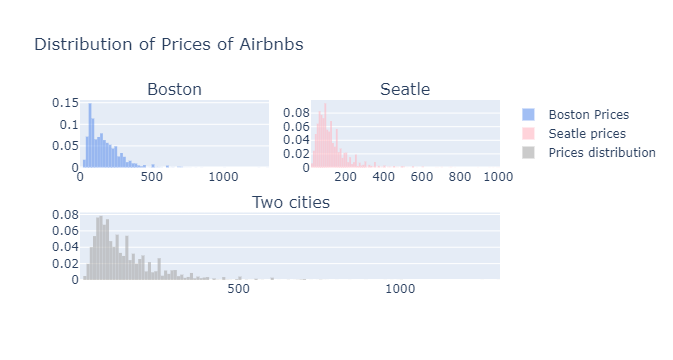

Null values: 0


In [11]:
price = listings['price'].values.tolist()
boston_price = listings['price'].loc[listings['city'] == 'Boston'].values.tolist()
seatle_price = listings['price'].loc[listings['city'] == 'Seatle'].values.tolist()

trace0 = go.Histogram(
    x=boston_price,
    histnorm='probability',
    name="Boston Prices",
    marker = dict(
        color = 'rgba(100, 149, 237, 0.6)',
    )
)
trace1 = go.Histogram(
    x= seatle_price,
    histnorm='probability',
    name="Seatle prices",
    marker = dict(
        color = 'rgba(255, 182, 193, 0.6)',
    )
)
trace2 = go.Histogram(
    x=price,
    histnorm='probability',
    name="Prices distribution",
     marker = dict(
        color = 'rgba(169, 169, 169, 0.6)',
    )
)
fig = tools.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Boston','Seatle', 'Two cities'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Distribution of Prices of Airbnbs', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

print("Null values:", listings.price.isnull().sum())

In [12]:
print(listings['price'].loc[listings['city'] == 'Boston'].max())
print(listings['price'].loc[listings['city'] == 'Seatle'].max())

1300
1000


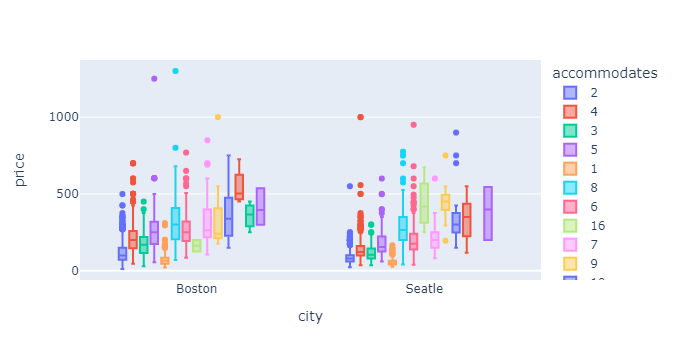

In [13]:
fig = px.box(listings, x="city", y="price", color= 'accommodates')
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

    For this variable we have no missing values. 
    On the other hand, it can be observed that we have quite skewed distributions, where the values of the prices vary up to $1300 in de Boston and $1000 in Seatle.

In [14]:
#We have already seen the number of listings based upon room type.Visualizing the same will provide more clarity.
def room_df(inputDF):
    room = inputDF.room_type
    r = Counter(room)

    room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
    room_df.columns = ['room_type']
    room_df.plot.pie(y = 'room_type', 
                     colormap = 'Blues_r', 
                     figsize=(5,5), 
                     fontsize = 20, autopct = '%.2f',
                     legend = False,
                     title = 'Room Type Distribution')

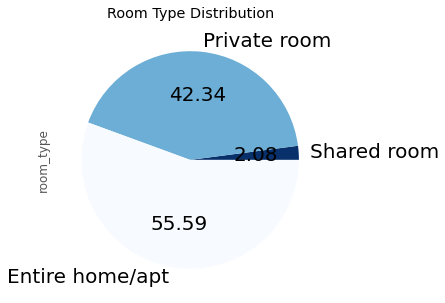

In [15]:
room_df(listings_boston)

In [16]:
listings_boston.groupby('room_type').id.count()

room_type
Entire home/apt    1393
Private room       1061
Shared room          52
Name: id, dtype: int64

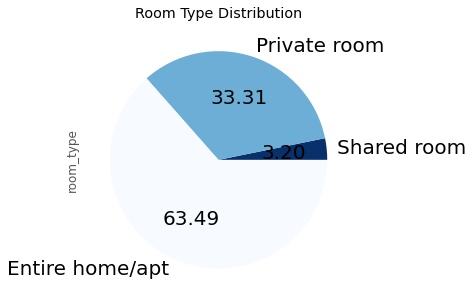

In [17]:
room_df(listings_seatle)

In [18]:
listings_seatle.groupby('room_type').id.count()

room_type
Entire home/apt    1805
Private room        947
Shared room          91
Name: id, dtype: int64

    It can be concluded that people are more inclined towards listing their entire property than that of private rooms or shared rooms.
    We can also find that Seatle has more rate to have "Entire home/apt" compare to Boston.
    It seem to me that house price can impact to this distribution.

In [15]:
# Analyzing and plotting the number of listings based on their property type
def propertytype_DF(inputDF):
    propertytype_DF = inputDF.groupby('property_type').id.count()
    propertytype_DF= propertytype_DF.reset_index()
    propertytype_DF=propertytype_DF.rename(columns={'id':'Number_Of_Listings'})

    objects = propertytype_DF['property_type']
    y_pos = propertytype_DF['Number_Of_Listings']

    propertytype_DF.plot(kind='bar', 
               x='property_type',
               y='Number_Of_Listings',
               color = '#66c2ff', 
               figsize =(10,4), 
               title = 'Boston Property Type Frequency', 
               legend = False)
    plt.ylabel('property type')
    plt.ylabel('Number of listings')

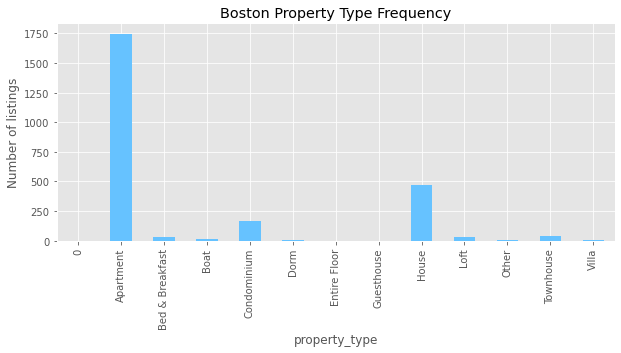

In [16]:
propertytype_DF(listings_boston)

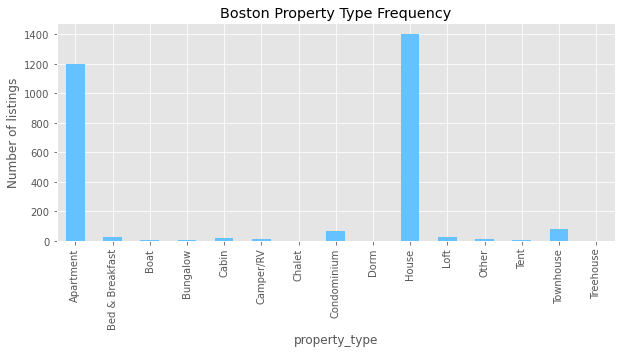

In [17]:
propertytype_DF(listings_seatle)

    It can also be seen that property type also plays an important factor. Not surprisingly, Apartment and houses take up an overwhelming majority of all listings, although we do see few instances unfamiliar residencies here and there.
    We can also find that Seatle has more "House" property_type compare to Boston and they have different property type.

In [18]:
# analyzing the prices for different room type and property type
def roomProperty_DF(inputDF): 
    roomProperty_DF = inputDF.groupby(['property_type','room_type']).price.mean()
    roomProperty_DF = roomProperty_DF.reset_index()
    roomProperty_DF=roomProperty_DF.sort_values('price',ascending=[0])
    return roomProperty_DF

In [19]:
roomProperty__boston_DF=roomProperty_DF(listings_boston)
roomProperty__boston_DF.head()

property_type        room_type       price
22     Townhouse  Entire home/apt  320.800000
13    Guesthouse  Entire home/apt  289.000000
7           Boat     Private room  287.000000
14         House  Entire home/apt  286.809917
6           Boat  Entire home/apt  275.222222

In [20]:
roomProperty__seatle_DF=roomProperty_DF(listings_seatle)
roomProperty__seatle_DF.head()

property_type        room_type       price
6           Boat  Entire home/apt  513.333333
19         House  Entire home/apt  194.824859
29     Townhouse  Entire home/apt  189.818182
22          Loft  Entire home/apt  178.933333
15   Condominium  Entire home/apt  170.490566

In [21]:
#Plotting the same on a heatMap
def plot_heatMap(inputDF): 
    plt.figure(figsize=(6,6))
    sns.heatmap(inputDF.groupby([
            'property_type', 'room_type']).price.mean().unstack(),annot=True, fmt=".0f")

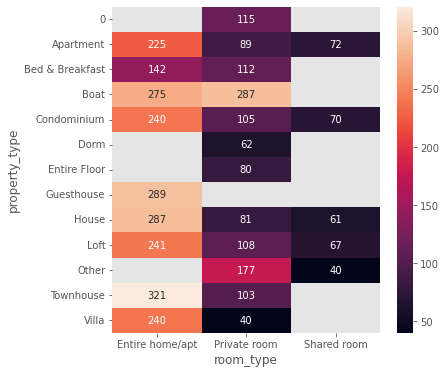

In [22]:
plot_heatMap(listings_boston)

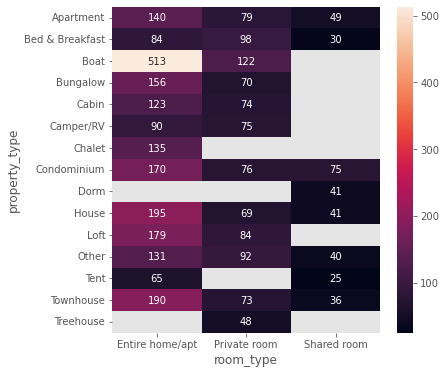

In [23]:
plot_heatMap(listings_seatle)

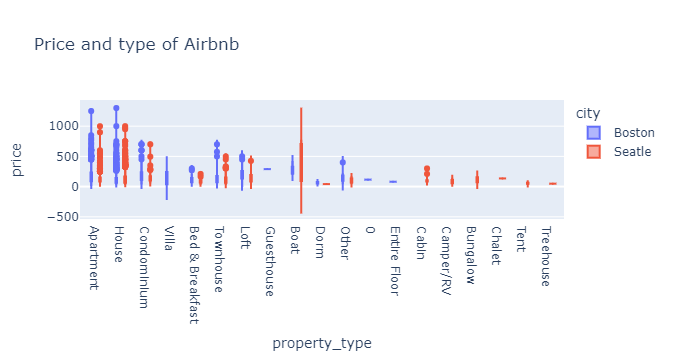

In [59]:
px.violin(listings, y="price", x="property_type", color="city", box=True, title="Price and type of Airbnb")

    This chart allows us to see all the listings' prices broken down by property type and room type. This gives us a much better understanding of the price breakdown based on property and room types.
    It can be analyzed that for almost all property type,prices for Entire home/apartment is the maximum.This tells us that Property type and room type plays a very important role in deciding price of a listing.
    We can find that Townhouse is maximum in Boston while Boat is maximum in Seatle.
    I think that regional characteristics can affect to this.
    
    Lets see how the number of bedrooms available affects the price of a listing

In [24]:
# HeatMap for variation of prices with number of bedrooms for listings
def plot_heatMap_bedrooms(inputDF): 
    plt.figure(figsize=(15,15))
    sns.heatmap(inputDF.groupby([
            'neighbourhood_cleansed', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".0f")

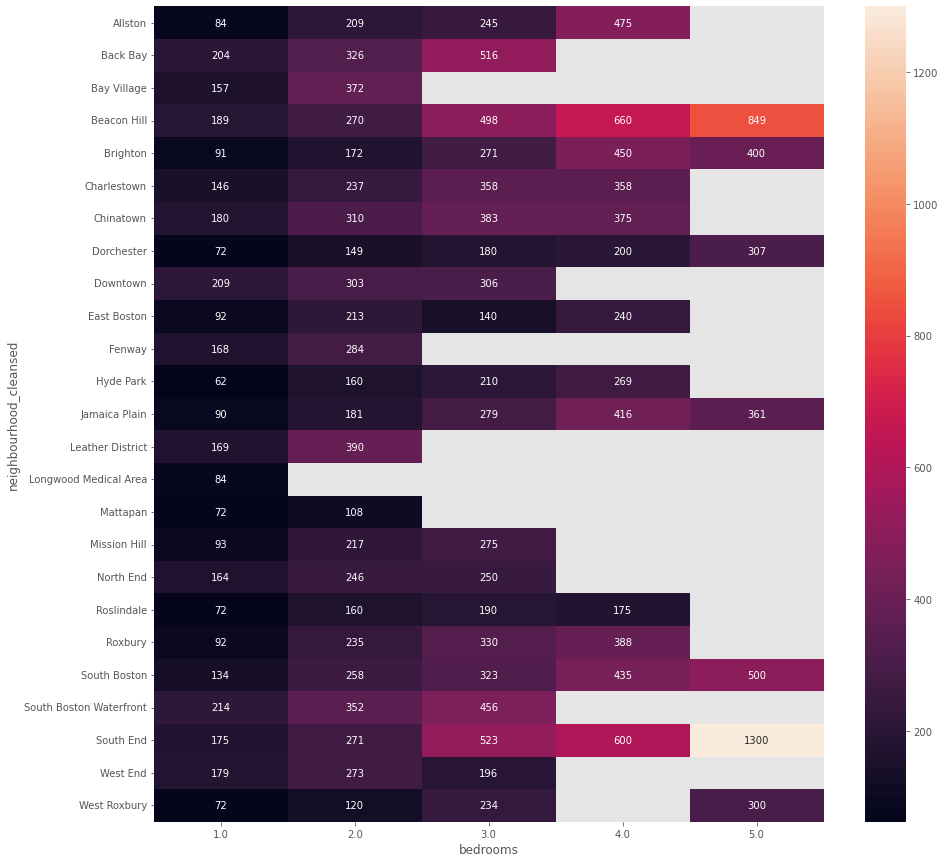

In [25]:
plot_heatMap_bedrooms(listings_boston)

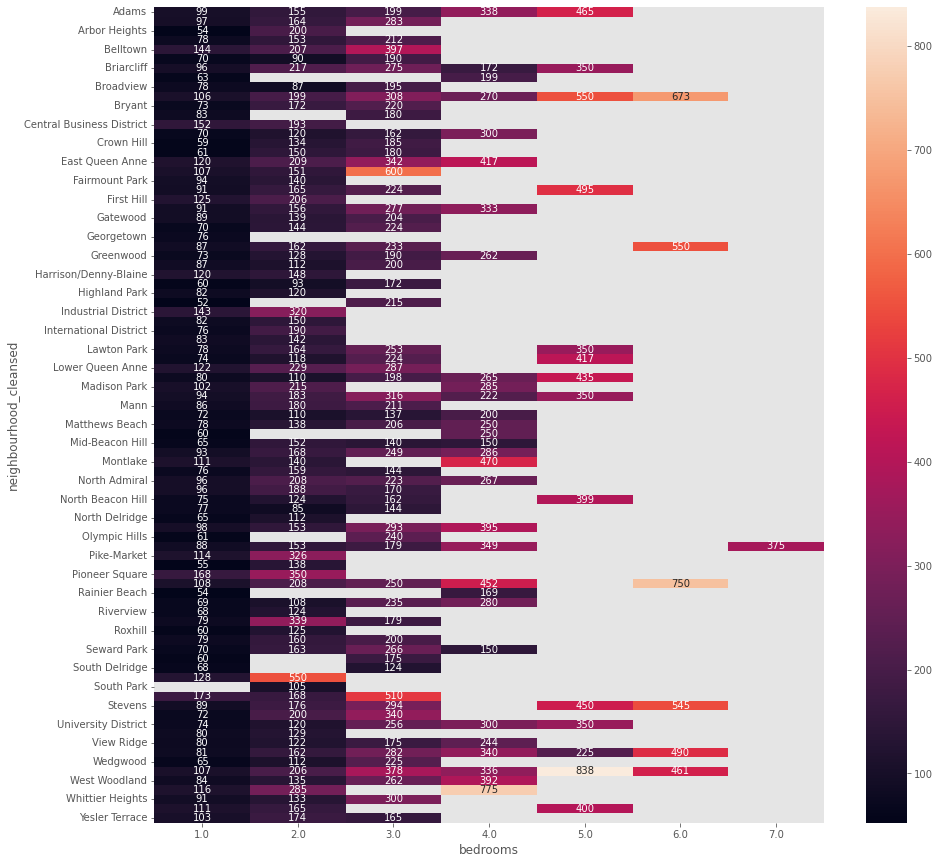

In [26]:
plot_heatMap_bedrooms(listings_seatle)

    It can be analyzed that with the increase in the number of bedrooms price of listing increases.Although, it depends upon the neighbourhood as well.

    So the analysis gives us data points that the prices of listings on Airbnb depends upon the room type, property type, number of bedrooms and neighbourhood.
    It can be seen that the property with type as Apartment and the listing as with type as entire house with maximum number of bedooms has highest price.
    Although it depends upon neighbourhood as well.
    Seatle has many neighbourhood data ans it has more impact to price compare to Boston.

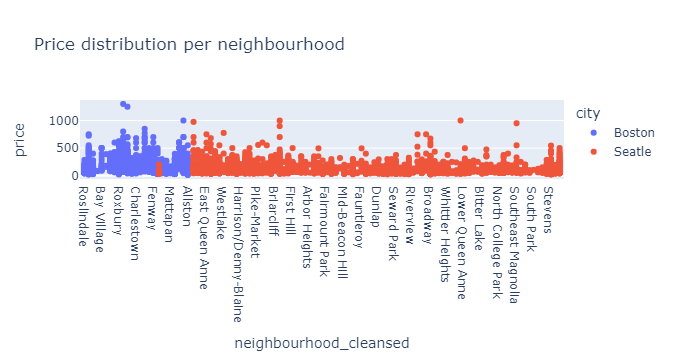

In [29]:
fig = px.strip(listings, y="price", x="neighbourhood_cleansed", color="city", 
           title="Price distribution per neighbourhood")

fig.show()

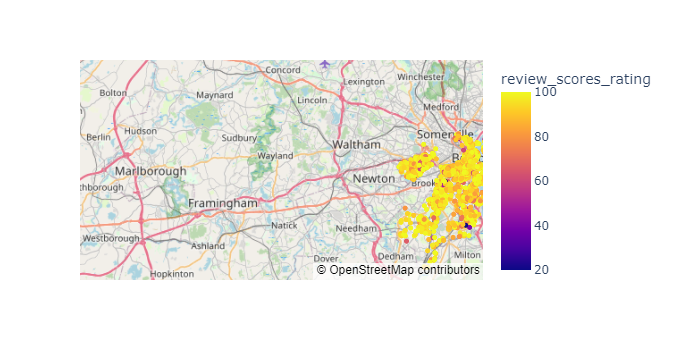

In [47]:
fig = px.scatter_mapbox(listings_boston, lat="latitude", lon="longitude", color='review_scores_rating', zoom=12, size_max=15, mapbox_style='open-street-map')
fig.show()

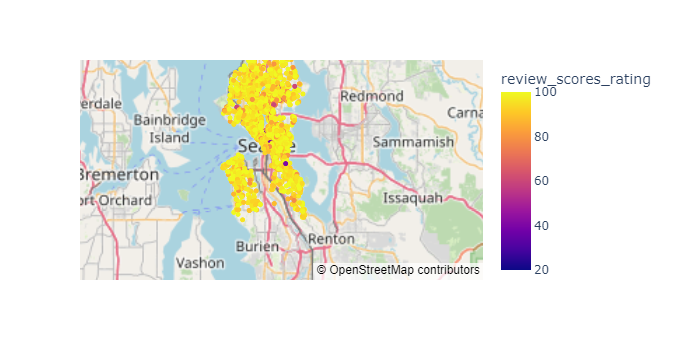

In [51]:
fig = px.scatter_mapbox(listings_seatle, lat="latitude", lon="longitude", color='review_scores_rating', zoom=10, mapbox_style='open-street-map')
fig.show()